In [1]:
from pcmdpy import gpu_utils, instrument as ins
import time

Vendor:  Continuum Analytics, Inc.
Package: mkl


GPU acceleration enabled


Message: trial mode expires in 28 days


In [2]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from scipy.misc import ascent
from scipy.signal import fftconvolve
from tqdm import tqdm
%matplotlib inline

/n/home01/bcook/.conda/envs/my_home/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from scipy.signal import fftconvolve
from scipy.signal.signaltools import _centered

In [4]:
from scipy import misc

In [5]:
from pycuda import gpuarray

In [6]:
from scipy import signal

In [7]:
#from pyfft.cuda import Plan

In [8]:
gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available


In [9]:
from pcmdpy import instrument as ins

In [10]:
f = ins.Filter.HST_F475W(10.)
psf = f._psf[0,0]
psf.shape

(73, 73)

In [11]:
gauss_kernel_huge = np.outer(signal.gaussian(4096, 3), signal.gaussian(4096, 3))
gauss_kernel = np.outer(signal.gaussian(512, 3), signal.gaussian(512, 3))
gauss_kernel_small = np.outer(signal.gaussian(73, 3), signal.gaussian(73, 3))

In [12]:
image = ascent()
image.shape

(512, 512)

In [90]:
image_huge = np.tile(image, (12, 12))
image_huge.shape

(6144, 6144)

In [14]:
#plt.imshow(image_huge,cmap='Greys_r')

In [15]:
def next_power2(n):
    return int(2**np.ceil(np.log2(n)))

In [166]:
def assert_valid_dims(in1, in2):
    try:
        assert(in1.ndim == in2.ndim)
    except:
        raise AssertionError('Input arrays must have same dimensions')

In [167]:
def get_shapes(in1, in2):
    assert_valid_dims(in1, in2)
    s1, s2 = np.array(in1.shape), np.array(in2.shape)
    fshape = [next_power2(s1[i] + s2[i] - 1) for i in range(in1.ndim)]
    return s1, s2, fshape

In [168]:
def pad_end(a, new_shape):
    new_shape = tuple(new_shape)
    assert(a.ndim == len(new_shape))
    assert(a.shape <= new_shape)
    s_temp = np.array(a.shape)
    return np.pad(a, [(0, new_shape[i] - s_temp[i]) for i in range(a.ndim)], 'constant')

In [169]:
def pad_both(in1, in2):
    assert_valid_dims(in1, in2)
    ndim = in1.ndim
    s1, s2, fshape = get_shapes(in1, in2)
    fslice = tuple([slice(0, int(s1[i]+s2[i]-1)) for i in range(ndim)])
    pad1 = [(0,fshape[i] - s1[i]) for i in range(ndim)]
    pad2 = [(0,fshape[i] - s2[i]) for i in range(ndim)]
    new1 = np.pad(in1, pad1, 'constant')
    new2 = np.pad(in2, pad2, 'constant')
    return new1, new2, fslice

In [170]:
#borrowed from scipy.signal.signaltools
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

In [171]:
def fftconvolve_gpu(in1, in2, mode='valid', plan=None, real=True):
    if mode not in ['valid', 'same', 'full']:
        raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')
    assert_valid_dims(in1, in2)
    in1 = in1.astype(np.complex64)
    in2 = in2.astype(np.complex64)
    s1, s2, fshape = get_shapes(in1, in2)
    if plan is None:
        plan = Plan(tuple(fshape))
    in1, in2, fslice = pad_both(in1, in2)
    in1_g = gpuarray.to_gpu(in1)
    in2_g = gpuarray.to_gpu(in2)
    plan.execute(in1_g)
    plan.execute(in2_g)
    
    convolved_g = in1_g * in2_g
    plan.execute(convolved_g, inverse=True)
    result = convolved_g[fslice].get()
    
    if real:
        result = np.real(result)
    if mode == 'valid':
        return _centered(result, s1-s2+1)
    elif mode == 'same':
        return _centered(result, s1)
    elif mode == 'full':
        return result
    else:
        raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')

In [172]:
class GPU_convolver:
    
    def __init__(self, psf, image_shape):
        self.psf = psf
        self.psf_shape = np.array(self.psf.shape)
        self.ndim = self.psf.ndim
        assert(self.ndim == len(image_shape))
        self.image_shape = np.array(image_shape)
        self.fslice = tuple([slice(0, int(self.image_shape[i]+self.psf_shape[i]-1))
                             for i in range(self.ndim)])
        
        self.fshape = tuple([next_power2(self.image_shape[i] + self.psf_shape[i] - 1) for i in range(self.ndim)])
        psf_temp = pad_end(self.psf, self.fshape).astype(np.complex64)

        self.plan = Plan(self.fshape)
        
        self.psf_g = gpuarray.to_gpu(psf_temp)
        self.plan.execute(self.psf_g)
        
    def reset_psf(self, psf):
        self.psf = psf
        self.psf_shape = np.array(self.psf.shape)
        self.ndim = self.psf.ndim
        assert(self.ndim == len(self.image_shape))
        self.fslice = tuple([slice(0, int(self.image_shape[i]+self.psf_shape[i]-1))
                             for i in range(self.ndim)])
        
        self.fshape = tuple([next_power2(self.image_shape[i] + self.psf_shape[i] - 1) for i in range(self.ndim)])

        psf_temp = pad_end(psf, self.fshape).astype(np.complex64)

        self.plan = Plan(self.fshape)
        
        self.psf_g = gpuarray.to_gpu(psf_temp)
        self.plan.execute(self.psf_g)
        
    def reset_image_shape(self, image_shape):
        self.image_shape = np.array(image_shape)
        assert(self.ndim == len(self.image_shape))
        self.fslice = tuple([slice(0, int(self.image_shape[i]+self.psf_shape[i]-1))
                             for i in range(self.ndim)])
        self.fshape = tuple([next_power2(self.image_shape[i] + self.psf_shape[i] - 1) for i in range(self.ndim)])
        
        psf_temp = pad_end(psf, self.fshape).astype(np.complex64)
        self.plan = Plan(self.fshape)
        self.psf_g = gpuarray.to_gpu(psf_temp)
        self.plan.execute(self.psf_g)
        
    def fftconvolve(self, image, real=True, mode='valid'):
        if mode not in ['valid', 'same', 'full']:
            raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')
        try:
            assert(image.shape == tuple(self.image_shape))
        except:
            raise AssertionError('Image is required to have shape: ' + str(self.image_shape)
                                 + ' , not: ' + str(image.shape))
            
        image_pad = pad_end(image, self.fshape).astype(np.complex64)
        im_g = gpuarray.to_gpu(image_pad)
        self.plan.execute(im_g)
        
        convolved_g = im_g * self.psf_g
        self.plan.execute(convolved_g, inverse=True)
        result = convolved_g[self.fslice].get()
    
        if real:
            result = np.real(result)
        if mode == 'valid':
            return _centered(result, self.image_shape-self.psf_shape+1)
        elif mode == 'same':
            return _centered(result, self.image_shape)
        elif mode == 'full':
            return result
        else:
            raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')

In [203]:
kernel = psf
times_cpu = []
times_gpu = []
# sizes = [128, 200, 256, 400, 512, 800, 1024, 1500, 2048, 3000, 4096]
sizes = [128, 256, 512, 1024, 2048, 4096]
convolver = GPU_convolver(g_kernel, image.shape)
for d in tqdm(sizes):
    im = image_huge[:d, :d]
    #cpu test
    start = time.time()
    _ = fftconvolve(im, kernel, mode='same')
    times_cpu.append(time.time()-start)
    #gpu test
    convolver.reset_image_shape(im.shape)
    start = time.time()
    _ = convolver.fftconvolve(im, real=True, mode='valid')
    times_gpu.append(time.time()-start)

100%|██████████| 6/6 [00:08<00:00,  2.34s/it]▎      | 2/6 [00:00<00:00, 19.64it/s]


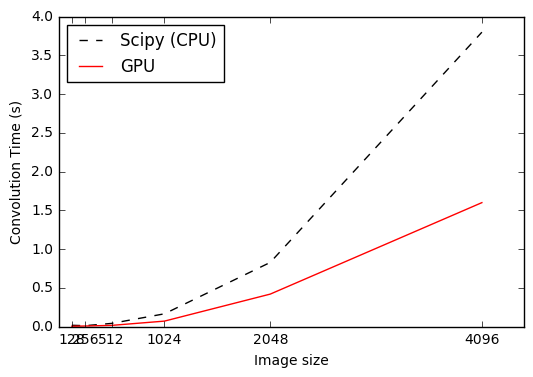

In [204]:
plt.plot(sizes, times_cpu, 'k--', label='Scipy (CPU)')
plt.plot(sizes, times_gpu, 'r-', label='GPU')
plt.ylabel('Convolution Time (s)')
plt.xticks(sizes), plt.xlabel('Image size')
plt.legend(loc=0)
plt.savefig('figures/GPU_convolution.pdf')

In [24]:
def centered( image, newshape=None):
    #Center the quandrants of the image
    result = image.copy()
    shift =  1 - (np.array(result.shape) / 2)
    for i in range(image.ndim):
        result = np.roll(result, shift[i], axis=i)
    #Remove exterior border
    if newshape is not None:
        start = (np.array(result.shape) - np.array(newshape)) / 2
        end = start + np.array(newshape)
        myslice = tuple([slice(start[k], end[k]) for k in range(len(newshape))])
        result = result[myslice]
    return result

In [15]:
from reikna.fft import FFT, FFTShift
import reikna.cluda as cluda

In [88]:
%%time
t = cluda.cuda_api().Thread.create()

CPU times: user 22 ms, sys: 259 ms, total: 281 ms
Wall time: 291 ms


In [26]:
t.release()

In [19]:
im1 = gpuarray.to_gpu(image.astype(np.complex64))
im2 = gpuarray.to_gpu(gauss_kernel.astype(np.complex64))
output1 = gpuarray.GPUArray(im1.shape, np.complex64)
output2 = gpuarray.GPUArray(im2.shape, np.complex64)
output1i = gpuarray.GPUArray(im1.shape, np.complex64)

In [20]:
fft = FFT(im1)

In [21]:
fftc = fft.compile(t)

In [22]:
%%time
truth = fftconvolve(image, gauss_kernel, mode='same')

CPU times: user 129 ms, sys: 25 ms, total: 154 ms
Wall time: 153 ms


In [25]:
%%time
fftc(output1, im1)
fftc(output2, im2)
result_g = output1 * output2
fftc(result_g, result_g, inverse=True)
result = result_g.get().real
result = centered(result)#, newshape=(np.array(result.shape) - (gauss_kernel_small.shape) + 1))

CPU times: user 4 ms, sys: 1e+03 µs, total: 5 ms
Wall time: 5.23 ms


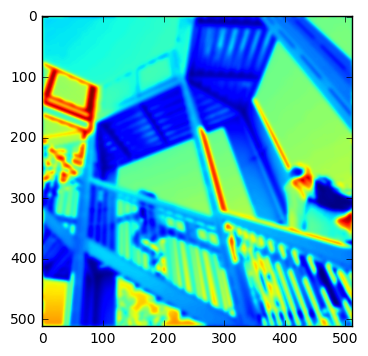

In [91]:
plt.imshow(result)

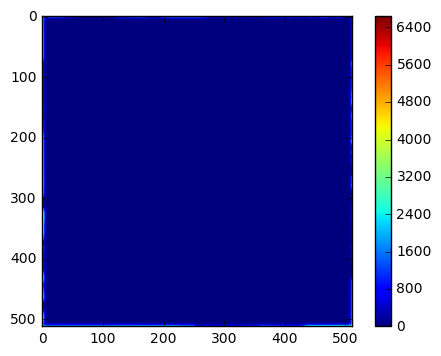

In [92]:
plt.imshow(result - truth)
plt.colorbar()

In [61]:
gpu_convolver.close()
reload(gpu_utils)

GPU acceleration enabled


<module 'pcmdpy.gpu_utils' from '/n/home01/bcook/pixcmd/pcmdpy/gpu_utils.py'>

In [62]:
gpu_convolver = gpu_utils.PSFConvolver(image.shape, gauss_kernel_small.shape)

In [91]:
%%time
truth = fftconvolve(image_huge, gauss_kernel, mode='same')

CPU times: user 6.94 s, sys: 4.83 s, total: 11.8 s
Wall time: 11.7 s


In [86]:
%%time
result = gpu_convolver.convolve_image(image_huge, gauss_kernel)

CPU times: user 1.62 s, sys: 2.81 s, total: 4.43 s
Wall time: 4.42 s


In [81]:
%%time
result = gpu_convolver.convolve_image(image_huge, gauss_kernel, mode='valid')

CPU times: user 1.65 s, sys: 2.81 s, total: 4.46 s
Wall time: 4.45 s


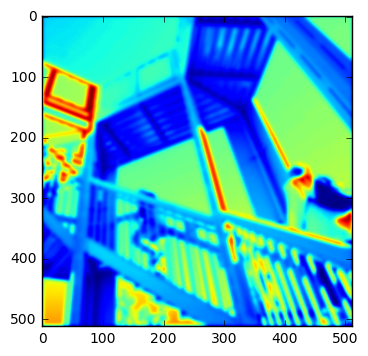

In [71]:
plt.imshow(truth)

In [84]:
gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available


In [87]:
gpu_utils.draw_image(np.random.random(50), np.random.random((2,50)), 512, gpu=True, cudac=True, fixed_seed=True)

array([[[  8.12244415,  12.60530376,  14.88063049, ...,   7.90995979,
          13.42866993,  15.02792263],
        [ 15.47065639,  18.19746399,  11.78046799, ...,  12.24591255,
          11.19236374,  17.06676674],
        [ 14.55219364,  16.83765984,  13.51623821, ...,  18.06877708,
          12.87927818,  14.805233  ],
        ..., 
        [  8.89793587,  10.49215794,  11.2905283 , ...,  13.03862286,
          17.72829056,  11.14488411],
        [  9.93665981,  12.90280437,  15.90155315, ...,  12.37914562,
          18.53619003,  10.9135685 ],
        [ 11.03694344,  16.35541916,   8.14140415, ...,   7.00162888,
          11.74712467,  14.21991634]],

       [[  9.80764866,  10.95353222,  12.04529572, ...,   7.2929759 ,
          12.17079926,  13.87263489],
        [ 15.95356178,  15.32083893,   8.44258881, ...,  11.90019035,
          12.01891518,  15.05189514],
        [ 14.79103279,  13.91120243,  13.20492554, ...,  15.20785618,
          11.8919611 ,  14.59202862],
        ...,

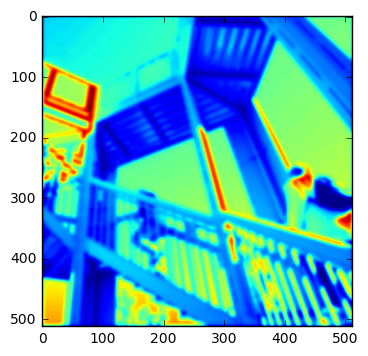

In [72]:
plt.imshow(result)

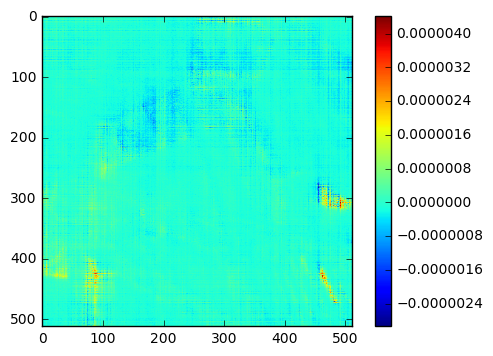

In [75]:
plt.imshow((result - truth) / truth)
plt.colorbar()

In [ ]:
gauss_kern

In [22]:
result.shape

(440, 440)